# Basic Usage

This tutorial walks through the basic usage of the `pynrc` package to calculate sensitivities and saturation limits for NIRCam in a variety of modes. 

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

## Getting Started

We assume you have already installed `pynrc` as outlined in the documentation.

In [2]:
# import main module
import pynrc
from pynrc import nrc_utils

Log messages for `pynrc` follow the same the logging functionality included in `webbpsf`. Logging levels include `DEBUG`, `INFO`, `WARN`, and `ERROR`. 

In [3]:
pynrc.setup_logging()

pyNRC log messages of level INFO and above will be shown.
pyNRC log outputs will be directed to the screen.


If you get tired of the `INFO` level messages, simply type:
```python
pynrc.setup_logging('WARN', verbose=False)
```    

## First NIRCam Observation

The basic NIRCam object consists of all the instrument settings one would specify for a JWST observation, including filter, pupil, and coronagraphic mask selections along with detector subarray settings and ramp sampling cadence (i.e., `MULTIACCUM`).

The NIRCam class makes use of high order polynomial coefficient maps to quickly generate large numbers of monochromatic PSFs that can be convolved with arbitrary spectra and collapsed into a final broadband PSF (or dispersed with NIRCam's slitless grisms). The PSF coefficients are calculated from a series of WebbPSF monochromatic PSFs and saved to disk. These polynomial coefficients are further modifed based on focal plane position and drift in the wavefront error relative to nominal OPD mao.

There are a multitude of posssible keywords one can pass upon initialization, including certain detector settings and PSF generation parameters. If not passed initially, then defaults are assumed. The user can update these parameters at any time by either setting attributes directly (e.g., `filter`, `mask`, `pupil`, etc.) along with using the `update_detectors()` and `update_psf_coeff()` methods.

For instance,
```python
nrc = pynrc.NIRCam('F210M')
nrc.module = 'B'
nrc.update_detectors(read_mode='DEEP8', nint=10, ngroup=5)
```
is the same as:
```python
nrc = pynrc.NIRCam('F210M', module='B', read_mode='DEEP8', nint=10, ngroup=5)
```

To start, we'll set up a simple observation using the `F430M` filter. Defaults will be populated for unspecified attributes such as `module`, `pupil`, `mask`, etc. 

**Check the function docstrings for more detailed information**

In [4]:
nrc = pynrc.NIRCam(filter='F430M', fov_pix=33, oversample=4)
print('\nFilter: {};  Pupil Mask: {};  Image Mask: {};  Module: {}'\
      .format(nrc.filter, nrc.pupil_mask, nrc.image_mask, nrc.module))

[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL
[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting ngroup=1, nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5
[     pynrc:INFO] Suggested SIAF aperture name: NRCA5_FULL
[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting ngroup=1, nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5
[webbpsf_ext:INFO] Loading /home/jarronl/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F430M_CLEAR_NONE_pix33_os4_jsig5_r0.00_th+0.0_RevWslice0_siwfe_distort_legendre.fits
[     pynrc:INFO] Suggested SIAF aperture name: NRCA5_FULL

Filter: F430M;  Pupil Mask: None;  Image Mask: None;  Module: A


Keyword information for detector settings are stored in the `det_info` dictionary. These cannot be modified directly, but instead are updated via the `update_detectors()` methods.

In [5]:
print('Detector Info Keywords:')
print(nrc.det_info)

Detector Info Keywords:
{'wind_mode': 'FULL', 'nout': 4, 'xpix': 2048, 'ypix': 2048, 'x0': 0, 'y0': 0, 'read_mode': 'RAPID', 'nint': 1, 'ngroup': 1, 'nf': 1, 'nd1': 0, 'nd2': 0, 'nd3': 0}


PSF settings are stored and modified in the same manner as WebbPSF (https://webbpsf.readthedocs.io/en/stable/usage.html) with a couple minor modifications:
  1. The calculated field of view is specified as `nrc.fov_pix` along with the `nrc.oversample` attributes. 
  2. In addition, you can turn on/off distortions via the `nrc.include_distortions` attribute.
  3. The primary method for calculating PSFs has changed to `nrc.calc_psf_from_coeff`.
  
You can quickly obtain a brief overview of important settings through the `psf_info` dictionary property. These properties can also be updated via the `nrc.update_psf_coeff()` function, which immediately generates a new set of PSF coefficients.

In [6]:
print('PSF Info:')
print(nrc.psf_info)

PSF Info:
{'fov_pix': 33, 'oversample': 4, 'npsf': 7, 'ndeg': 6, 'include_si_wfe': True, 'include_distortions': True, 'jitter': 'gaussian', 'jitter_sigma': 0.005, 'offset_r': 0, 'offset_theta': 0, 'bar_offset': None, 'pupil': '/home/jarronl/NIRCam/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz', 'pupilopd': ('OPD_RevW_ote_for_NIRCam_predicted.fits', 0)}


PSF coefficient information is stored in the `psf_coeff` attribute. An associated header file exists in the `psf_coeff_header`, showing all of the parameters used to generate that data. This data is accessed by many of the NIRCam class functions to generate PSFs with arbitrary wavelength weights, such as the `calc_psf_from_coeff()` function.

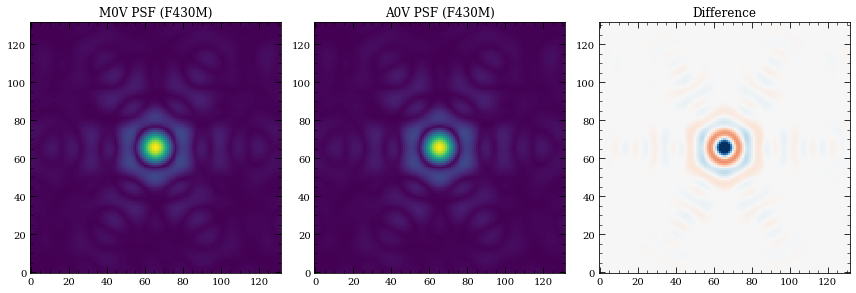

In [7]:
# Demonstrate the color difference of the PSF for different spectral types, same magnitude
sp_M0V = pynrc.stellar_spectrum('M0V', 10, 'vegamag', nrc.bandpass)
sp_A0V = pynrc.stellar_spectrum('A0V', 10, 'vegamag', nrc.bandpass)

# Generate oversampled PSFs (counts/sec)
hdul_M0V = nrc.calc_psf_from_coeff(sp=sp_M0V, return_oversample=True)
hdul_A0V = nrc.calc_psf_from_coeff(sp=sp_A0V, return_oversample=True)

psf_M0V = hdul_M0V[0].data
psf_A0V = hdul_A0V[0].data

fig, axes = plt.subplots(1,3, figsize=(12,4))

axes[0].imshow(psf_M0V**0.5)
axes[0].set_title('M0V PSF ({})'.format(nrc.filter))
axes[1].imshow(psf_A0V**0.5)
axes[1].set_title('A0V PSF ({})'.format(nrc.filter))

diff = psf_M0V - psf_A0V

minmax = np.abs(diff).max() / 2
axes[2].imshow(diff, cmap='RdBu', vmin=-minmax, vmax=minmax)
axes[2].set_title('Difference')

fig.tight_layout()

Bandpass information is stored in the `bandpass` attribute and can be plotted with the convenience function `plot_bandpass()`.

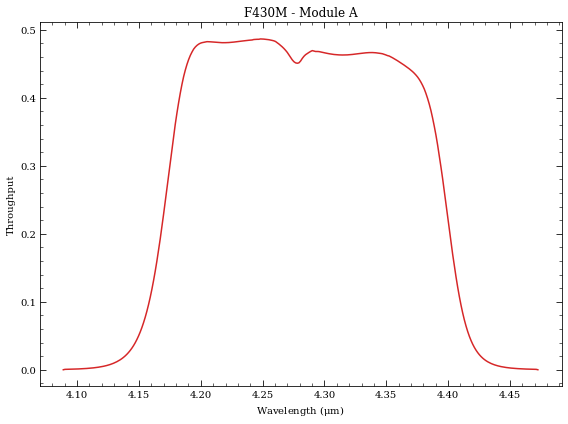

In [8]:
fig, ax = plt.subplots(1,1)
nrc.plot_bandpass(ax=ax, color='C3')

fig.tight_layout()

## 1. Saturation Limits

One of the most basic functions is to determine the saturation limit of a CDS observation, so let's try this for the current filter selection. Generally, saturation is considered to be 80% of the full well, but can go as high as 95%.

In [9]:
# Turn off those pesky informational texts
pynrc.setup_logging('WARN', verbose=False)

# Configure the observation for CDS frames (ngroup=2)
# Print out frame and ramp information using verbose=True
nrc.update_detectors(ngroup=2, verbose=True)

New Ramp Settings
  read_mode  :    RAPID
  nf         :        1
  nd2        :        0
  ngroup     :        2
  nint       :        1
New Detector Settings
  wind_mode  :     FULL
  xpix       :     2048
  ypix       :     2048
  x0         :        0
  y0         :        0
New Ramp Times
  t_group    :   10.737
  t_frame    :   10.737
  t_int      :   21.474
  t_int_tot1 :   21.474
  t_int_tot2 :    0.000
  t_exp      :   21.474
  t_acq      :   21.479


The `sat_limits()` function returns a dictionary of results. There's the option in include a Pysynphot spectrum, but if None is specificed then it defaults to a G2V star.

In [10]:
# Set verbose=True to print results in a user-friendly manner
sat_lims = nrc.sat_limits(verbose=True)

# Dictionary information
print("\nDictionary Info:", sat_lims)

F430M Saturation Limit assuming G2V source (point source): 12.16 vegamag
F430M Saturation Limit assuming G2V source (extended): 8.46 vegamag/arcsec^2

Dictionary Info: ({'satlim': 12.159015250560046, 'units': 'vegamag', 'bp_lim': 'F430M', 'Spectrum': 'G2V'}, {'satlim': 8.456428360335746, 'units': 'vegamag/arcsec^2', 'bp_lim': 'F430M', 'Spectrum': 'G2V'})


By default, the function `sat_limits()` uses a G2V stellar spectrum, but any arbritrary spectrum can be passed via the `sp` keyword. In addition, using the `bp_lim` keyword, you can use spectral information to determine the brightness in some other bandpass that saturates the source within the NIRCam filter. 

In [11]:
# Spectrum of an M0V star (not normalized)
sp_M0V = pynrc.stellar_spectrum('M0V')
# 2MASS Ks Bandpass
bp_k = pynrc.bp_2mass('K')

sat_lims = nrc.sat_limits(sp=sp_M0V, bp_lim=bp_k, verbose=True)

Ks-Band Saturation Limit for F430M assuming M0V source (point source): 12.30 vegamag
Ks-Band Saturation Limit for F430M assuming M0V source (extended): 8.59 vegamag/arcsec^2


Now, let's get the same saturation limit assuming a 128x128 detector subarray (faster frame rate).

In [12]:
nrc.update_detectors(wind_mode='WINDOW', xpix=128, ypix=128)
sat_lims = nrc.sat_limits(sp=sp_M0V, bp_lim=bp_k, verbose=True)

Ks-Band Saturation Limit for F430M assuming M0V source (point source): 7.87 vegamag
Ks-Band Saturation Limit for F430M assuming M0V source (extended): 4.17 vegamag/arcsec^2


You can also use the `saturation_levels()` function to generate an image of a point source indicating the fractional well fill level.

In [13]:
# Spectum of A0V star with Ks = 8 mag
sp = pynrc.stellar_spectrum('M0V', 8, 'vegamag', bp_k)
sat_levels = nrc.saturation_levels(sp, full_size=False, ngroup=nrc.det_info['ngroup'])

print('Max Well Fraction: {:.2f}'.format(sat_levels.max()))

Max Well Fraction: 0.71


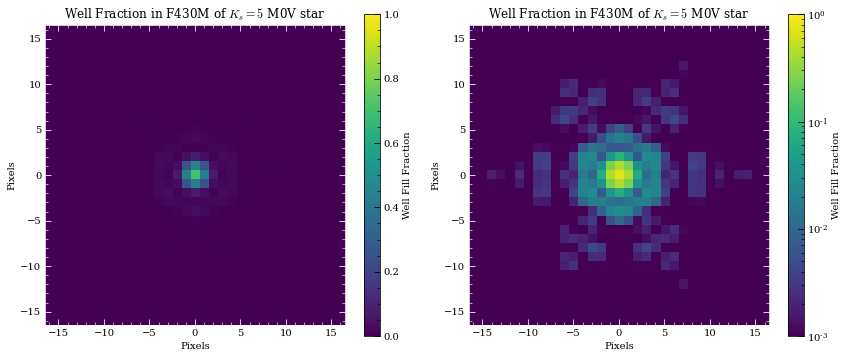

In [14]:
# Plot the well fill levels for each pixel
fig, axes = plt.subplots(1,2, figsize=(12,5))

for i,ax in enumerate(axes):
    extent = 0.5 * nrc.psf_info['fov_pix'] * np.array([-1,1,-1,1])
    if i==0:
        cax = ax.imshow(sat_levels, extent=extent, vmin=0, vmax=1)
    else:
        norm = matplotlib.colors.LogNorm(vmin=0.001, vmax=1)
        cax = ax.imshow(sat_levels, extent=extent, norm=norm)
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Pixels')
    ax.set_title('Well Fraction in {} of $K_s = 5$ M0V star'.format(nrc.filter))

    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Well Fill Fraction')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')
        
fig.tight_layout()

Information for slitless grism observations show wavelength-dependent results.

In [15]:
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', ngroup=2, wind_mode='STRIPE', ypix=128)
sat_lims = nrc.sat_limits(sp=sp_M0V, bp_lim=bp_k, verbose=True)

Ks-Band Saturation Limit for F444W assuming M0V source:
   Wave   Sat Limit (vegamag)
--------- -------------------
     3.90                4.41
     4.00                4.40
     4.10                4.29
     4.20                4.17
     4.30                4.02
     4.40                3.78
     4.50                3.60
     4.60                3.43
     4.70                3.25
     4.80                3.09
     4.90                2.88
     5.00                2.31


## 2. Sensitivity Limits

Similarly, we can determine sensitivity limits of point sources (and extended sources) for the defined instrument configuration. By default, the `sensitivity()` function uses a flat spectrum. In this case, let's find the sensitivities NIRCam can reach in a single ~1000sec integration with the F430M filter. Noise values will depend on the exact `MULTIACCUM` settings.

In [16]:
nrc = pynrc.NIRCam('F430M')
nrc.update_detectors(read_mode='MEDIUM8', ngroup=10)

# The multiaccum_times attribute describes the various timing information
print(nrc.multiaccum_times)

{'t_frame': 10.73677, 't_group': 107.3677, 't_int': 1052.20346, 't_exp': 1052.20346, 't_acq': 1052.2087, 't_int_tot1': 1052.20346, 't_int_tot2': 0.0}


In [17]:
sens = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

Point Source Sensitivity (5-sigma): 23.33 vegamag
Surface Brightness Sensitivity (5-sigma): 21.20 vegamag/arcsec^2


The sensitivity function also includes a keyword `forwardSNR`, which allows the user to pass a normalized spectrum and estimate the SNR For some extraction aperture.

In [18]:
sp = pynrc.stellar_spectrum('M0V', 20, 'vegamag', nrc.bandpass)
snr = nrc.sensitivity(sp=sp, forwardSNR=True, units='vegamag', verbose=True)

Point Source SNR (20.00 vegamag): 75.94 sigma
Surface Brightness SNR (20.00 vegamag/arcsec^2): 14.32 sigma


## 3. Ramp Optimization

Armed with these two basic functions, we can attempt to determine the best instrument settings to optimize for SNR and efficiency. In these types of optimizations, we must consider observational constraints such as saturation levels, SNR requirements, and limits on acquisition time.

**Note**: The reported acquisition times do not include obsevatory and instrument-level overheads, such as slew times, filter changes, script compilations, etc. It only includes detector readout times (including reset frames and Fast Row Resets).

For instance, we want to observe an M-Dwarf (K=18 mag) in the F430M filter. What is the most efficient configuration to obtain an SNR of 100?

In [19]:
# Setup observation
nrc = pynrc.NIRCam('F430M', wind_mode='WINDOW', xpix=160, ypix=160)

# Spectrum of an M2V star
bp_k = pynrc.bp_2mass('K')
sp_M0V = pynrc.stellar_spectrum('M0V', 18, 'vegamag', bp_k)

In [20]:
# Run optimizer. Result is a sorted by efficiency.
tbl = nrc.ramp_optimize(sp_M0V, snr_goal=100, ng_min=5, nint_min=10, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP8         5   10     24.52    245.20    248.04    114.3    0.005    7.254
MEDIUM8       7   11     18.95    208.42    211.54     99.8    0.004    6.861
MEDIUM8       7   12     18.95    227.37    230.78    104.2    0.004    6.861
MEDIUM2       9   10     22.85    228.48    231.32    100.3    0.004    6.597
MEDIUM2       9   11     22.85    251.33    254.46    105.2    0.004    6.597
SHALLOW4     10   18     13.65    245.76    250.87     99.0    0.003    6.248
SHALLOW4     10   19     13.65    259.41    264.81    101.7    0.003    6.248
SHALLOW4     10   20     13.65    273.07    278.74    104.3    0.003    6.248
DEEP2         5   12     22.85    274.18    277.59    102.2    0.004    6.131
SHALLOW2     10   23     13.10    301.21    307.74     99.6    0.003    5.

For a slightly more complicated scenario, consider an additional foreground source. In this scenario, the F0V star will saturate much more quickly compared to the fainter M2V, so it limits which ramp settings we may want to use (assuming we want unsaturated frames, which isn't always necessarily true).

In [21]:
sp_F0V = pynrc.stellar_spectrum('F0V', 10, 'vegamag', bp_k)
tbl = nrc.ramp_optimize(sp_M0V, sp_bright=sp_F0V, snr_goal=100, ng_min=5, nint_min=10, 
                        well_frac_max=0.9, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  637      2.79   1774.94   1955.72    100.0    0.765    2.261
RAPID        10  638      2.79   1777.72   1958.79    100.1    0.765    2.261
RAPID        10  639      2.79   1780.51   1961.86    100.2    0.765    2.261
RAPID        10  640      2.79   1783.30   1964.93    100.2    0.765    2.261
RAPID        10  641      2.79   1786.08   1968.00    100.3    0.765    2.261
RAPID        10  642      2.79   1788.87   1971.07    100.4    0.765    2.261
RAPID        10  643      2.79   1791.66   1974.14    100.5    0.765    2.261
RAPID        10  644      2.79   1794.44   1977.21    100.5    0.765    2.261
RAPID        10  645      2.79   1797.23   1980.28    100.6    0.765    2.261
RAPID        10  646      2.79   1800.01   1983.35    100.7    0.765    2.

If there are no objections to saturating the bright source, then we can set the `well_frac_max` parameter to something like 5 times the hard saturation limit. This allows for much more efficient exposure settings.

In [22]:
tbl = nrc.ramp_optimize(sp_M0V, sp_bright=sp_F0V, snr_goal=100, ng_min=5, nint_min=10, 
                        well_frac_max=5, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8       6   14     16.16    226.26    230.23     98.8    4.436    6.511
MEDIUM8       6   15     16.16    242.42    246.67    102.3    4.436    6.511
SHALLOW4     10   18     13.65    245.76    250.87     99.0    3.748    6.248
SHALLOW4     10   19     13.65    259.41    264.81    101.7    3.748    6.248
SHALLOW4     10   20     13.65    273.07    278.74    104.3    3.748    6.248
MEDIUM8       5   21     13.37    280.87    286.83    102.5    3.671    6.053
MEDIUM2       7   16     17.28    276.41    280.95     98.7    4.742    5.885
MEDIUM2       7   17     17.28    293.69    298.51    101.7    4.742    5.885
MEDIUM2       7   18     17.28    310.96    316.07    104.6    4.742    5.885
SHALLOW2     10   23     13.10    301.21    307.74     99.6    3.595    5.